In [1]:
from UTILITY_quickstart import *

In [2]:
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch.yml")
importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch.yml")

In [3]:
csrTF = True
evalElement = "PENT"


inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
bunchCount = importedDefaultSettings["bunchCount"]
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e5,
)

setLattice(tao, **importedDefaultSettings)


# activeSettings = importedDefaultSettings | {
#     # "S1EL_xOffset" : 0.00,  
#     # "S1EL_yOffset" : 0.0,  
#     # #"S2EL_xOffset" : 0.002,  
#     # "S2EL_yOffset" : 0.0,  
#     # "S2ER_xOffset" : 0.0,  
#     # "S2ER_yOffset" : 0.0,  
#     # "S1ER_xOffset" : 0.0,  
#     # "S1ER_yOffset" : 0.0,

#     # #"XC1FFkG" : 0.2321150061,


#     # #Sextupole compensated, CSR off
#     # "S2EL_xOffset" : 0.002, 
#     # "XC1FFkG" : 0.19,

# }
# setLattice(tao, **activeSettings)



#Rescale charge
# newCharge = 1e-12
# trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
# P = getBeamAtElement(tao, "L0AFEND")
# print(f"""\n\n\nAs imported charge: {P.charge}""")
# P.charge = newCharge
# makeBeamActiveBeamFile(P)
# tao.cmd('reinit beam')

#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))
print(f"""New charge: {PInit.charge}""")

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 100000.0
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting
New charge: 1.6000000000000005e-09


In [4]:
assertBC14Energy = importedDefaultSettings["assertBC14Energy"]
assertBC20Energy = importedDefaultSettings["assertBC20Energy"]
centerBC14 = importedDefaultSettings["centerBC14"] 
centerBC20 = importedDefaultSettings["centerBC20"] 
centerMFFF = importedDefaultSettings["centerMFFF"] 

In [5]:
trackBeam(tao, 
          #trackStart = "L0AFEND", 
          #trackEnd = evalElement, 
          centerBC14 = centerBC14, 
          centerBC20 = centerBC20, 
          centerMFFF = centerMFFF, 
          assertBC14Energy = assertBC14Energy, 
          assertBC20Energy = assertBC20Energy,  
          verbose = True
         )

Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Set track_end = BEGBC14_1
Tracking!
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = end
Set track_end = BEGBC20
Tracking!
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = end
Set track_end = MFFF
Tracking!
Beam centered at MFFF written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = MFFF, track_end = end
Tracking!
trackBeam() exiting


In [33]:
savedData = {}

evalElement = "PENT"
P = getBeamAtElement(tao, evalElement)

if bunchCount == 1:
    PDrive = P.copy()
    beamsToEvaluate = ["PDrive"]
elif bunchCount == 2:
    PDrive, PWitness = getDriverAndWitness(P)
    beamsToEvaluate = ["PDrive", "PWitness"]


if evalElement == "MFFF":
    #MFFF lucretia live model lattice 2024-10-16
    targetBetaX = 11.6
    targetBetaY = 25.2
    targetAlphaX = -0.64
    targetAlphaY = -1.6

if evalElement == "PENT":
    #These are the wishful twiss specs
    targetBetaX = 0.5
    targetBetaY = 0.5
    targetAlphaX = 0.0
    targetAlphaY = 0.0


for PActiveStr in beamsToEvaluate:
    PActive = locals()[PActiveStr]

    
    # for val in ["mean_x", "mean_y", "sigma_x", "sigma_y", "mean_xp", "mean_yp"]:
    #     savedData[f"{PActiveStr}_{val}"] = PActive[val]

    
    savedData[f"{PActiveStr}_median_x"] = np.median(PActive.x)
    savedData[f"{PActiveStr}_median_y"] = np.median(PActive.y)

    savedData[f"{PActiveStr}_median_xp"] = np.median(PActive.xp)
    savedData[f"{PActiveStr}_median_yp"] = np.median(PActive.yp)
    
    savedData[f"{PActiveStr}_sigmaSI90_x"] = smallestIntervalImpliedSigma(PActive.x, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_y"] = smallestIntervalImpliedSigma(PActive.y, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_z"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_sigmaSI90_xp"] = smallestIntervalImpliedSigma(PActive.xp, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_yp"] = smallestIntervalImpliedSigma(PActive.yp, percentage = 0.90)

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_norm_emit_x"] = PActive["norm_emit_x"]
    savedData[f"{PActiveStr}_norm_emit_y"] = PActive["norm_emit_y"]

    if bunchCount == 2:
        savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

    savedData[f"{PActiveStr}_charge_nC"] = PActive.charge * 1e9


    PActiveTwiss = PActive.twiss(plane = "x", fraction = 0.9) | PActive.twiss(plane = "y", fraction = 0.9)

    savedData[f"{PActiveStr}_BMAG_x"] = calcBMAG(targetBetaX, targetAlphaX, PActiveTwiss["beta_x"], PActiveTwiss["alpha_x"])
    savedData[f"{PActiveStr}_BMAG_y"] = calcBMAG(targetBetaY, targetAlphaY, PActiveTwiss["beta_y"], PActiveTwiss["alpha_y"])

    # Get BMAGs by energy slice
    slicedBeamlets = sliceBeam( PActive , sortKey = "pz", numBeamlets = 5 )

    slicedTwiss =  [ ( beamlet.twiss(plane = "x", fraction = 0.9) | beamlet.twiss(plane = "y", fraction = 0.9) ) for beamlet in slicedBeamlets ] 
    
    savedData[f"{PActiveStr}_sliced_BMAG_x"] = [ calcBMAG(targetBetaX, targetAlphaX, beamletTwiss["beta_x"], beamletTwiss["alpha_x"]) for beamletTwiss in slicedTwiss ]
    savedData[f"{PActiveStr}_sliced_BMAG_y"] = [ calcBMAG(targetBetaY, targetAlphaY, beamletTwiss["beta_y"], beamletTwiss["alpha_y"]) for beamletTwiss in slicedTwiss ]

if bunchCount == 2:
    savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

    savedData["transverseCentroidOffset"] = np.sqrt(
            (savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + 
            (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2
        )

savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

In [38]:

(getBeamAtElement(tao, "PENT")).write("beams/optimizerRunningBestBeam_PENT.h5")
savedData

{'PDrive_median_x': -2.2269970715121814e-06,
 'PDrive_median_y': -1.5933367608148e-07,
 'PDrive_median_xp': 9.805123697188399e-07,
 'PDrive_median_yp': -7.429418259240592e-08,
 'PDrive_sigmaSI90_x': 2.0318674136994763e-05,
 'PDrive_sigmaSI90_y': 1.1359743836401952e-05,
 'PDrive_sigmaSI90_z': 2.0234789034670913e-05,
 'PDrive_sigmaSI90_xp': 0.00013151467160654016,
 'PDrive_sigmaSI90_yp': 2.8298258430008007e-05,
 'PDrive_emitSI90_x': 4.93174600172721e-05,
 'PDrive_emitSI90_y': 5.7354049413151795e-06,
 'PDrive_norm_emit_x': 7.607997639550904e-05,
 'PDrive_norm_emit_y': 8.009370668272083e-06,
 'PDrive_charge_nC': 1.5996480000000006,
 'PDrive_BMAG_x': 1.4475224543647511,
 'PDrive_BMAG_y': 1.1408134510284962,
 'PDrive_sliced_BMAG_x': [2.868195867478884,
  1.07973318040296,
  4.1963539740014255,
  1.3207733905335863,
  1.7301152726908904],
 'PDrive_sliced_BMAG_y': [3.780793566884811,
  2.691988490902444,
  1.7585294300291476,
  1.6914979652245647,
  2.3276078946866297],
 'lostChargeFraction': 

In [35]:
if bunchCount == 2:
    print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")
    
    print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2) :.3g} um""")
    print(f"""Angular misalignment: \t{1e3*np.sqrt((savedData["PDrive_median_xp"] - savedData["PWitness_median_xp"])**2 + (savedData["PDrive_median_yp"] - savedData["PWitness_median_yp"])**2) :.3g} mrad""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
if bunchCount == 2:
    print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_z"] :.3g} um""")



print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
if bunchCount == 2: 
    print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g} × {1e6 * PDrive["sigma_y"] :.3g} × {1e6 * PDrive["sigma_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g} × {1e6 * PWitness["sigma_y"] :.3g} × {1e6 * PWitness["sigma_z"] :.3g} um""")


Emittances and sigmas - implied by 90% charge
Driver emittance: 	49.3 × 5.74 um-rad
Driver sigma_x,y,z: 	20.3 × 11.4 × 20.2 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	76.1 × 8.01 um-rad
Driver sigma_x,y,z: 	27.4 × 12.7 × 30.3 um


Drive:


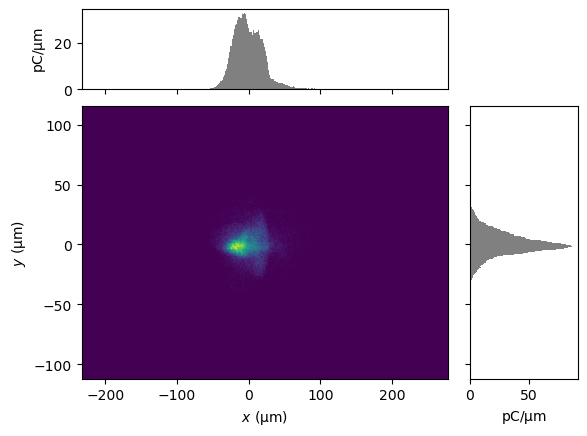

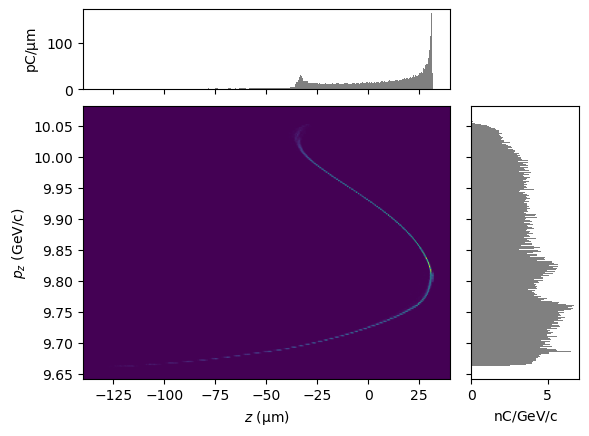

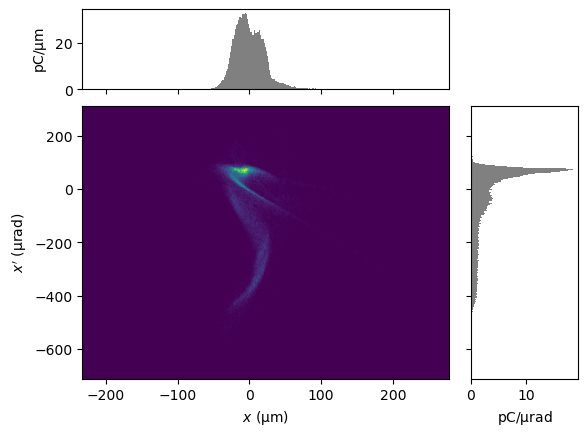

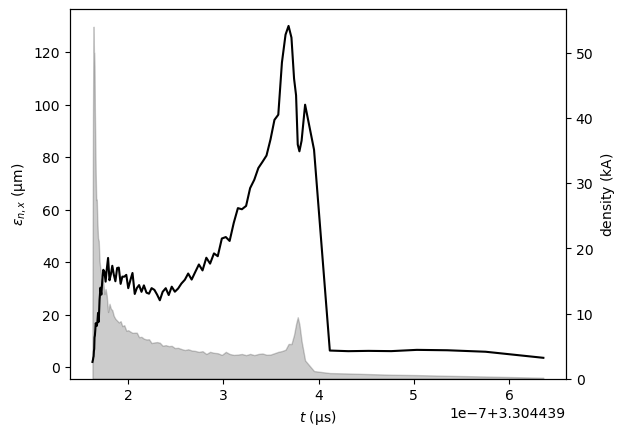

In [36]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
if bunchCount == 2:
    print("Witness:")
    display(plotMod(PWitness, 'x', 'y',  bins=300))
    
display(plotMod(PDrive, 'z', 'pz', bins=300))

display(plotMod(PDrive, 'x', 'xp', bins=300))
display(slicePlotMod(PDrive, 'norm_emit_x', slice_key = "t", n_slice=100))
plt.clf()

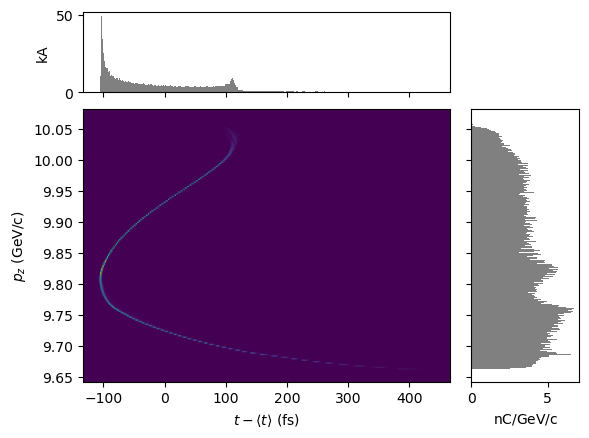

In [10]:
display(plotMod(PDrive, 'delta_t', 'pz', bins=300))

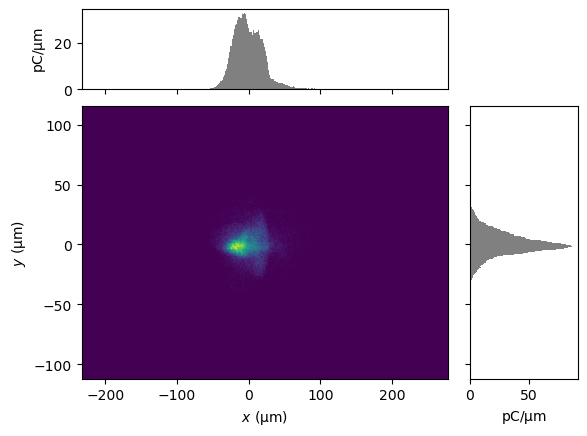

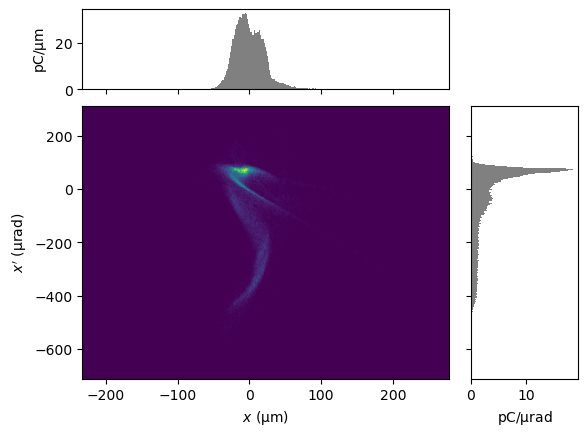

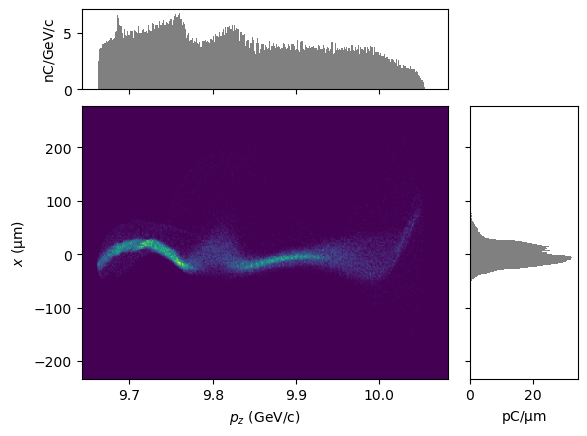

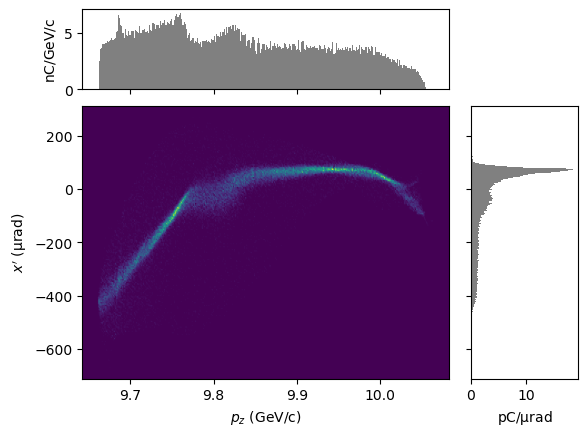

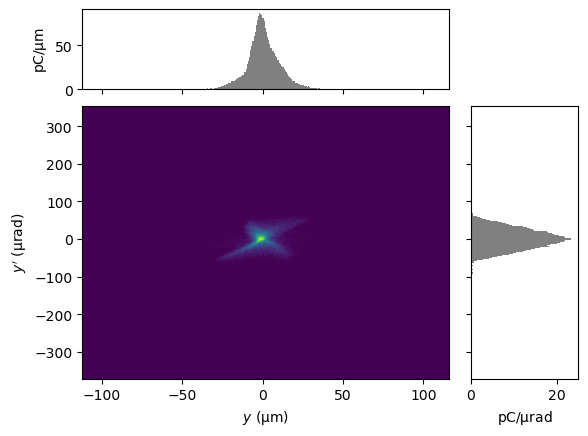

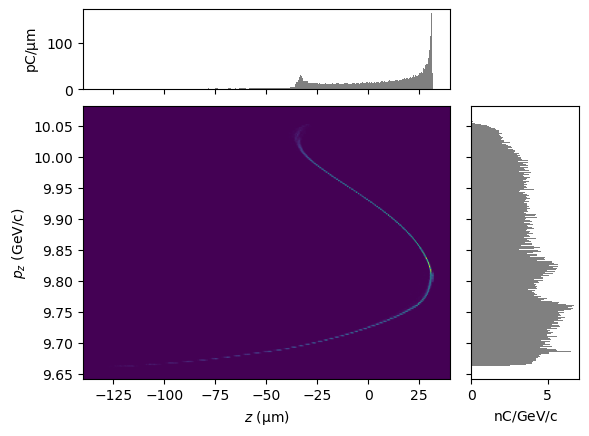

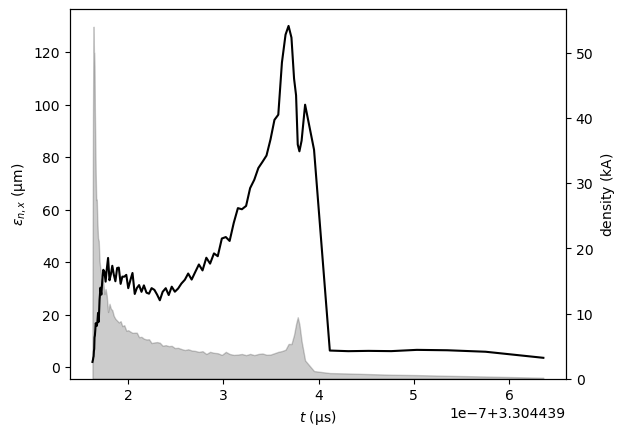

In [37]:
display(plotMod(PDrive, 'x', 'y',  bins=300))

display(plotMod(PDrive, 'x', 'xp', bins=300))
display(plotMod(PDrive, 'pz', 'x', bins=300))
display(plotMod(PDrive, 'pz', 'xp', bins=300))

display(plotMod(PDrive, 'y', 'yp', bins=300))
display(plotMod(PDrive, 'z', 'pz', bins=300))
display(slicePlotMod(PDrive, 'norm_emit_x',n_slice=100))

## Further study at other elements

In [12]:
?calcBMAG

Signature: calcBMAG(b0, a0, b, a)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [13]:
#def addBMAGToDict(dict, targetBeta, targetAlpha)

In [14]:
P = getBeamAtElement(tao, "PR10571")
#PDrive, PWitness = getDriverAndWitness(P)


#PR10571 lucretia live model lattice 2024-10-16
targetBetaX = 5.7
targetBetaY = 2.6
targetAlphaX = -2.1
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System BMAG:  1.0075548918301704, 1.0065856108012432

System emit:  2.3261958040146777e-06, 1.699280963507734e-06


In [15]:
P = getBeamAtElement(tao, "BEGBC20")
#PDrive, PWitness = getDriverAndWitness(P)


#BEGBC20 lucretia live model lattice 2024-10-16
targetBetaX = 11.5
targetBetaY = 27.3
targetAlphaX = 0.7
targetAlphaY = 1.2

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")


System BMAG:  1.0538105663274313, 1.1790668183818258

System emit:  6.00428281958868e-06, 2.5663886324716567e-06


In [16]:
P = getBeamAtElement(tao, "MFFF")
#PDrive, PWitness = getDriverAndWitness(P)
PDrive = P


#MFFF lucretia live model lattice 2024-10-16
targetBetaX = 11.6
targetBetaY = 25.2
targetAlphaX = -0.64
targetAlphaY = -1.6

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 15.997677956366633, 67.34983064852432
Drive alpha x / y: -2.8391474694478105, -4.093714318696801

System BMAG:  2.439944114303234, 1.529617706353957

System emit:  2.290392624194886e-05, 2.096030206158633e-06


In [17]:
P = getBeamAtElement(tao, "PENT")
#PDrive, PWitness = getDriverAndWitness(P)

#PENT lucretia live model lattice 2024-10-16
targetBetaX = 0.5
targetBetaY = 0.5
targetAlphaX = 0.0
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System beta x / y: {PTwiss["beta_x"]}, {PTwiss["beta_y"]}""")
print(f"""System alpha x / y: {PTwiss["alpha_x"]}, {PTwiss["alpha_y"]}""")

#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

#print(f"""Witness beta x / y: {PWitnessTwiss["beta_x"]}, {PWitnessTwiss["beta_y"]}""")
#print(f"""Witness alpha x / y: {PWitnessTwiss["alpha_x"]}, {PWitnessTwiss["alpha_y"]}""")

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System beta x / y: 0.29609912641103264, 0.36166799012220124
System alpha x / y: 0.603110077967132, -0.35660607318897874
System BMAG:  1.4475224543647511, 1.1408134510284962

System emit:  2.3519804284396454e-05, 3.5088091170415865e-06


PR10571


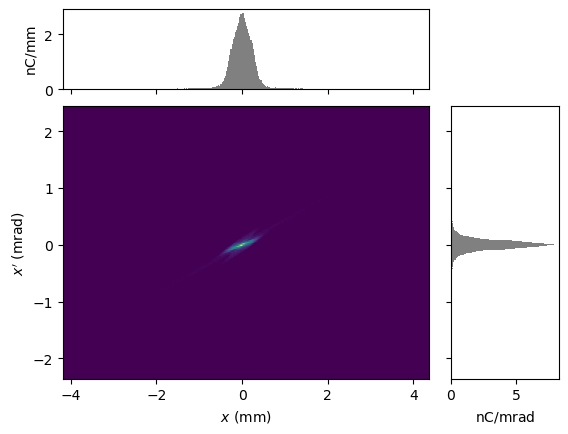

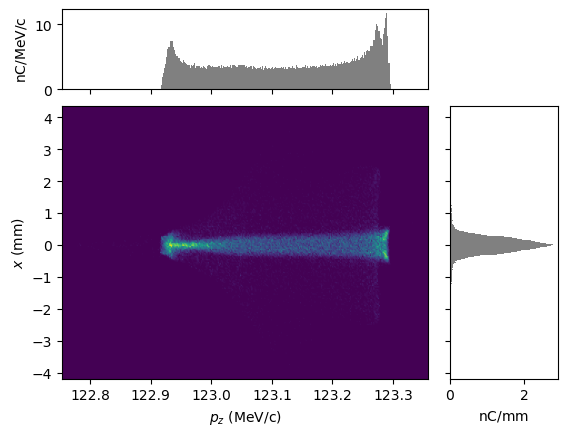

BEGBC20


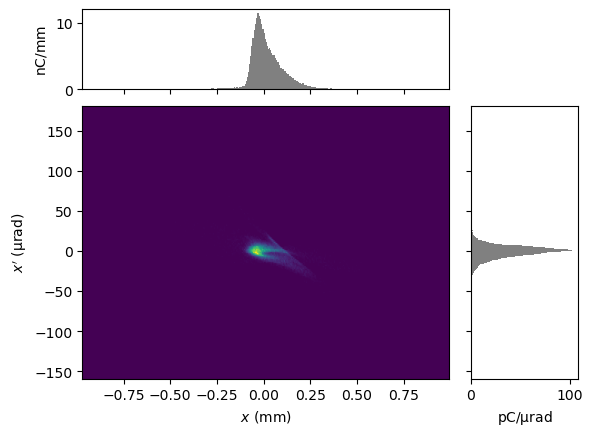

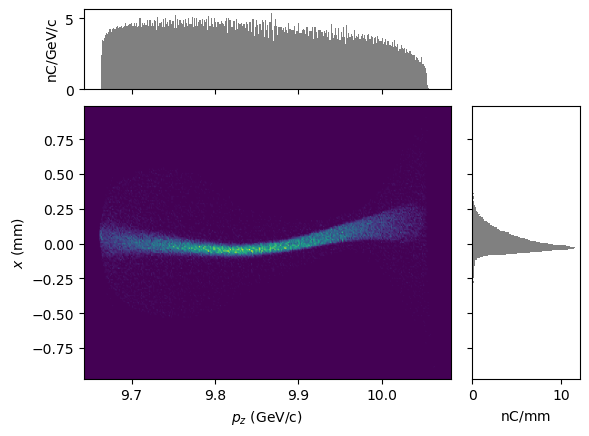

MFFF


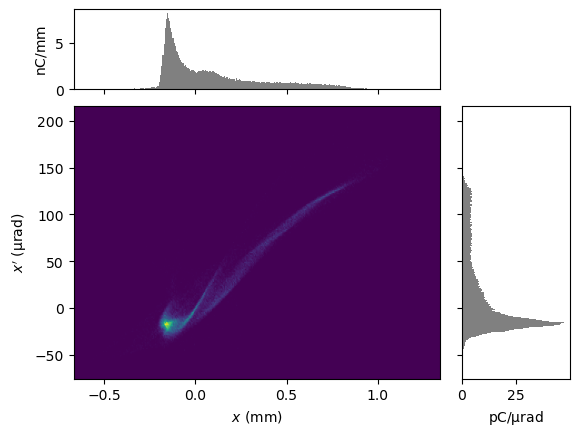

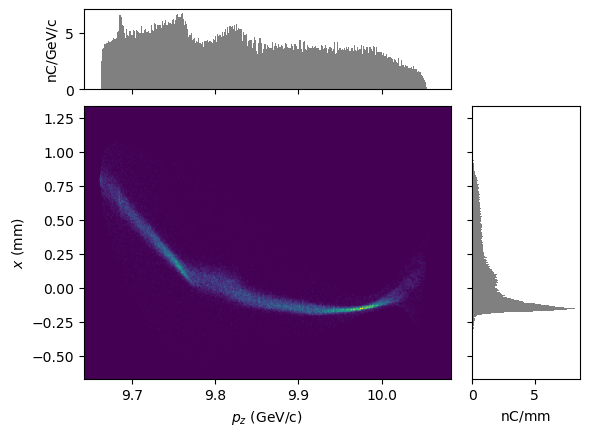

PENT


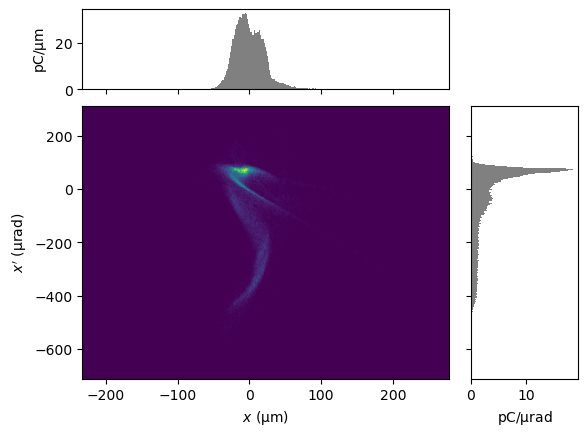

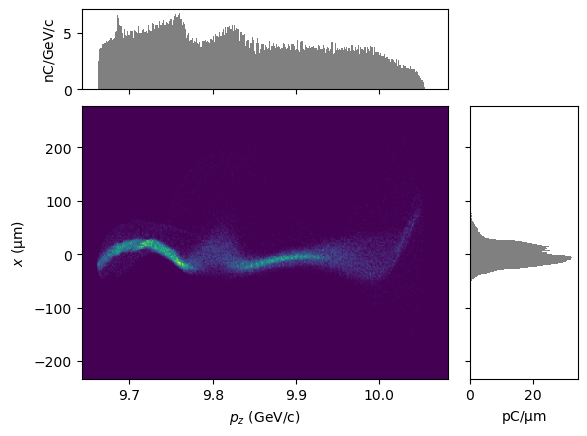

In [18]:

for activeElement in ["PR10571", "BEGBC20", "MFFF", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    #PDrive, PWitness = getDriverAndWitness(P)
    
    display(plotMod(P, 'x', 'xp',  bins=300))
    display(plotMod(P, 'pz', 'x',  bins=300))

# Check beam specs at treaty points

In [19]:
print("DL10")
getMatrix(tao,"LH10END", "BEGL1F",print=True);
print("BC11")
getMatrix(tao,"BEGBC11_1", "BEGL2F",print=True);
print("BC14")
getMatrix(tao,"ENDL2F", "BEGL3F_1",print=True);
print("BC20")
getMatrix(tao,"BEGBC20", "MFFF",print=True);

DL10


4.371024,-1.089037,0.000000,0.000000,0.000000,0.000000
-0.938919,0.462710,-0.000000,-0.000000,0.000000,-0.000000
0.000000,0.000000,-0.716651,-2.107302,0.000000,0.000000
0.000000,0.000000,-0.023472,-1.464398,0.000000,0.000000
0.000000,0.000000,0.000000,0.000000,1.000000,-0.006136
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC11


5.503387,-24.775546,0.000000,0.000000,0.000000,-0.000000
-0.203411,1.097438,-0.000000,-0.000000,0.000000,0.000000
-0.000000,0.000000,0.353439,2.781447,0.000000,0.000000
0.000000,-0.000000,-0.601774,-1.906419,0.000000,-0.000000
-0.000000,0.000000,-0.000000,-0.000000,1.000000,0.046019
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC14


-0.008002,17.783581,0.000000,0.000000,0.000000,0.000007
-0.056770,1.195609,0.000000,-0.000000,0.000000,0.000001
0.000000,-0.000000,-1.165446,35.842067,0.000000,0.000000
-0.000000,-0.000000,-0.003119,-0.762114,0.000000,-0.000000
-0.000000,-0.000016,-0.000000,0.000000,1.000000,0.036014
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC20


-1.445698,-5.169377,0.018146,-0.030944,0.000000,0.022236
-0.193141,-1.382246,0.007420,-0.006798,0.000000,0.001383
-0.014643,-0.042151,-1.035870,2.579871,0.000000,-0.003140
0.005565,0.008763,-0.099534,-0.717377,0.000000,-0.000434
-0.002319,-0.023633,0.000002,0.003264,1.000000,-0.008474
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [20]:
P = getBeamAtElement(tao, "L0BFEND")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""SI90 emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")
print(f"""norm_emit: {1e6 * P["norm_emit_x"]}, {1e6 * P["norm_emit_y"]} um-rad""")

E: 0.12312282148965241 GeV 
sig_z: 568.026056666026 um
sig_E: 0.08559478787344982 %


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:434: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


SI90 emittance: 3.6081355213481383, 2.6611856470018442 um-rad
norm_emit: 6.58214067681437, 5.115120146939446 um-rad


In [21]:
P = getBeamAtElement(tao, "BEGL2F")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 0.33131814286686323 GeV 
sig_z: 465.6277238265755 um
sig_E: 0.19505193435383403 %


In [22]:
P = getBeamAtElement(tao, "BEGL3F_1")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 4.430356492667381 GeV 
sig_z: 38.07367028583422 um
sig_E: 1.3620076388506974 %


In [23]:
P = getBeamAtElement(tao, "BEGBC20")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")

E: 9.844263951220213 GeV 
sig_z: 38.0668877704361 um
sig_E: 1.02848459488366 %
emittance: 11.354815262274037, 4.6187220995277 um-rad


In [24]:
P = getBeamAtElement(tao, "PENT")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 9.832688833267724 GeV 
sig_z: 20.22079046848077 um
sig_E: 1.001596920269573 %


In [25]:
importedDefaultSettings

{'QA10361kG': -3.1976079537,
 'QA10371kG': 3.1129092742,
 'QE10425kG': -6.8469996218,
 'QE10441kG': 1.5057761462,
 'QE10511kG': 7.0138622173,
 'QE10525kG': -5.3942250594,
 'B1EkG': 7.533,
 'B2EkG': -10.942,
 'B3EkG': 3.409,
 'Q1EkG': 161.311,
 'Q2EkG': -154.229,
 'Q3EkG': 110.217,
 'Q4EkG': 132.268,
 'Q5EkG': -23.373,
 'Q6EkG': -142.271,
 'symmetricSextupoleStrengths': True,
 'S1ELkG': 1198.3974976341,
 'S2ELkG': -3135.3072427404,
 'S3ELkG': -1614.159195231,
 'S3ERkG': -1019.323,
 'S2ERkG': -2049.489,
 'S1ERkG': 804.871,
 'Q5FFkG': -71.837,
 'Q4FFkG': -81.251,
 'Q3FFkG': 99.225,
 'Q2FFkG': 126.35,
 'Q1FFkG': -235.218,
 'Q0FFkG': 126.353,
 'Q0DkG': -109.694,
 'Q1DkG': 180.862,
 'Q2DkG': -109.694,
 'S1EL_xOffset': 0.0007730129,
 'S1EL_yOffset': -0.0001312114,
 'S2EL_xOffset': -0.0004352787,
 'S2EL_yOffset': -2.92591e-05,
 'S2ER_xOffset': -0.0006924693,
 'S2ER_yOffset': -0.0008549877,
 'S1ER_xOffset': -7.48848e-05,
 'S1ER_yOffset': -0.0010639993,
 'XC1FFkG': 0.0,
 'XC3FFkG': 0.0,
 'YC1FFk

L0AFEND


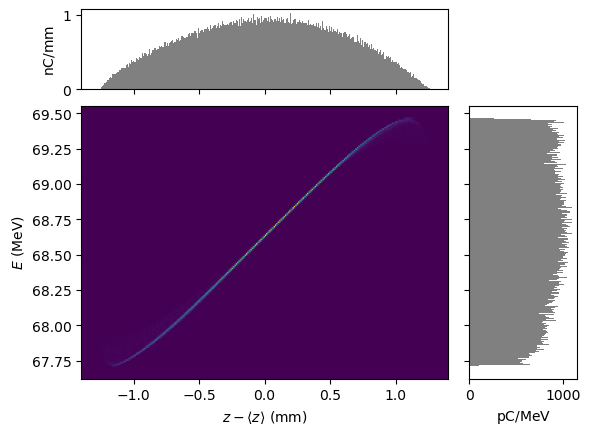

BEGL2F


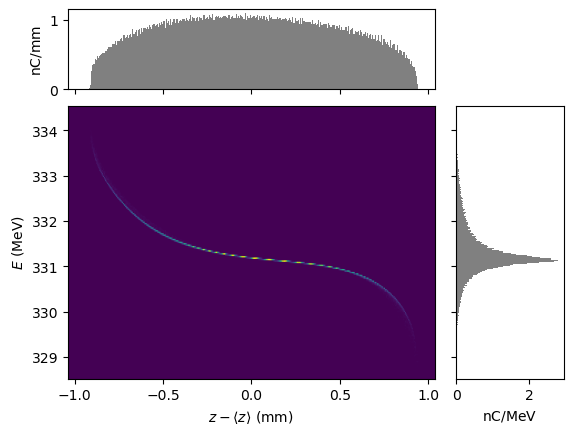

BEGL3F_1


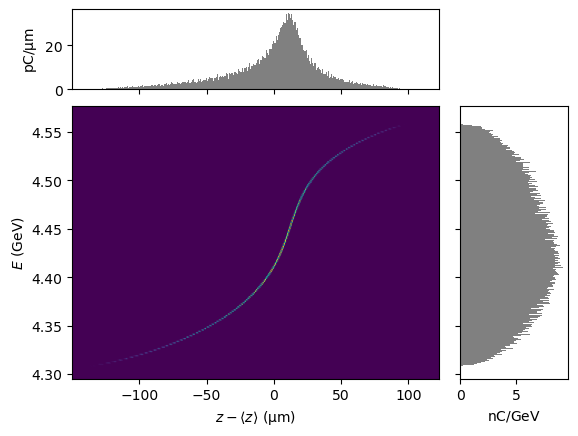

BEGBC20


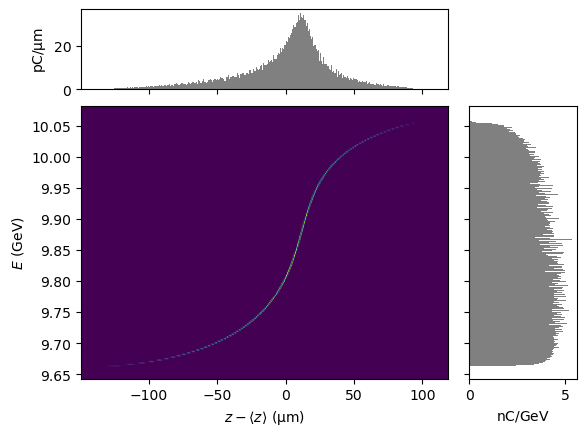

PENT


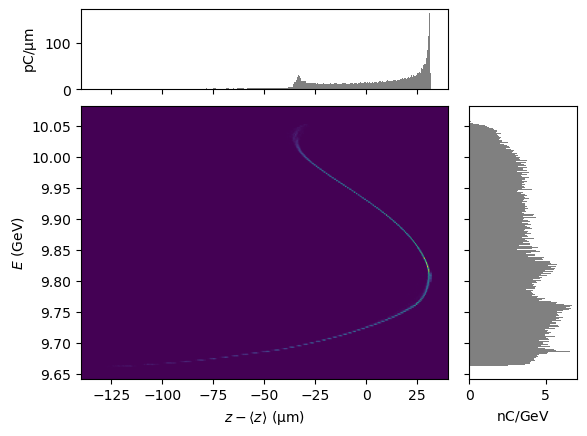

In [26]:
for activeElement in ["L0AFEND","BEGL2F","BEGL3F_1", "BEGBC20", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    display(plotMod(P, 'delta_z', 'energy',  bins=300))

In [27]:
# for activePhase in np.arange(-40, -25, 1):
#     print(activePhase)
#     setLinacPhase(tao, "L2", activePhase)
#     setLinacGradientAuto(tao, "L2", 4.5e9 - 0.335e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     activeElement = "BEGBC20"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.5e-3, 0.5e-3), ylim = (9.5e9, 10.5e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.2e-3, 0.2e-3), ylim = (9.6e9, 10.2e9) ) )
    

In [28]:
# for activePhase in np.arange(-39.0, -33.0, 0.5):
#     print(activePhase)
#     setLinacPhase(tao, "L2", activePhase)
#     setLinacGradientAuto(tao, "L2", 4.5e9 - 0.335e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     # activeElement = "BEGBC20"
#     # P = getBeamAtElement(tao, activeElement)
#     # print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     # display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.1e-3, 0.1e-3), ylim = (9.6e9, 10.0e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     #print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     print(f"""{activeElement}: {1e6 * smallestIntervalImpliedSigma(P.t * 3e8, percentage=0.9)}""")
    
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.1e-3, 0.1e-3), ylim = (9.6e9, 10.0e9) ) )

In [29]:
# for activePhase in np.arange(-75, 0, 5):
#     print(activePhase)
#     setLinacPhase(tao, "L3", activePhase)
#     setLinacGradientAuto(tao, "L3", 10e9 - 4.5e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     activeElement = "BEGBC20"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.5e-3, 0.5e-3), ylim = (9.5e9, 10.5e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.2e-3, 0.2e-3), ylim = (9.6e9, 10.2e9) ) )

In [30]:
getMatrix(tao, "BEGBC20", "PENT", print=True);

-0.198356,-2.330516,0.014199,-0.010490,0.000000,-0.000746
0.705267,3.245379,-0.014078,0.017883,0.000000,-0.009189
-0.018472,-0.031267,0.182297,2.460361,0.000000,0.001207
-0.027851,-0.052894,-0.116096,3.918091,0.000000,0.000241
-0.002378,-0.023895,-0.000043,0.004025,1.000000,-0.008474
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [31]:
?getMatrix

Signature: getMatrix(tao, start, end, order=1, print=False)
Docstring: Return zero or first order transport matrix from start to end. Optionally print in a human readable format
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function